## Email Spam Filtering
Written by Jack Utzerath 

The purpose of this program is to detect wether or not an email is spam by using the Bayesian model

## Importing Libraries

In [1]:
import re
import nltk
import pandas as pd
import numpy as np
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold
from gensim.models import Word2Vec
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jacku\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jacku\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jacku\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Reading in the File

This email dataset has three columns. The first column is a unique identifier for each email. This column is not useful. The second column contains the body text of the emails which varies from "spam" to "ham". This column need to be handeled and procesed. The third column categorizes each email as either spam or not spam. 

In [2]:
data = pd.read_csv('completeSpamAssassin.csv')
print(data.head())
# Droping the first column 
data = data.drop(columns=['Unnamed: 0'])

# Count the number of spam and not spam emails
spam_count = data[data['Label'] == 1].shape[0]
not_spam_count = data[data['Label'] == 0].shape[0]

spam_count, not_spam_count


   Unnamed: 0                                               Body  Label
0           0  \nSave up to 70% on Life Insurance.\nWhy Spend...      1
1           1  1) Fight The Risk of Cancer!\nhttp://www.adcli...      1
2           2  1) Fight The Risk of Cancer!\nhttp://www.adcli...      1
3           3  ##############################################...      1
4           4  I thought you might like these:\n1) Slim Down ...      1


(1896, 4150)

After dropping the first column and counting the number of spam and not spam emails, this dataset appears to not be balanced which may lead to model basis in the future

In addition to this, the dataset is starts out by listing all spam data first followed by all the non spam data last. 

Lets create a balanced dataset and then shuffle the data in order to prevent bias. This will also create the random distribution of data needed for cross-validation consistency

In [3]:
# Find the minimum count to balance the dataset
min_count = min(spam_count, not_spam_count)

# Create a balanced dataset by sampling
spam_sample = data[data['Label'] == 1].sample(n=min_count, random_state=42)
not_spam_sample = data[data['Label'] == 0].sample(n=min_count, random_state=42)

balanced_data = pd.concat([spam_sample, not_spam_sample])

# Shuffle the dataset to mix spam and not spam emails
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Dropping NaN values from the 'Body' column in the balanced_data
balanced_data.replace('empty', np.nan, inplace=True)
balanced_data = balanced_data.dropna(subset=['Body'])

#extract on the email column in 
email_data = balanced_data[['Body']]



## Cleaning the Data

Removing unnecessary headers, footers, and quoting from emails by utilizing the "re" library

In [4]:

def clean_email(email):
    email = str(email)

    # Remove email addresses
    cleaned_email = re.sub(r'\S*@\S*\s?', '', email)
    # Enhanced URL removal
    url_pattern = r'https?://[-\w.]+(\[-\w./?%&=]*[\w./?%&=])?|www\.\S+'
    cleaned_email = re.sub(url_pattern, '', cleaned_email)
    # Remove newlines
    cleaned_email = re.sub(r'\n', ' ', cleaned_email)
    # Remove newlines and encoded characters
    cleaned_email = re.sub(r'\n', ' ', cleaned_email)
    cleaned_email = re.sub(r'&\S+;', ' ', cleaned_email)  # Handles common HTML entities
    cleaned_email = re.sub(r'\*{2,}', '', cleaned_email)  # Removes the ***** sequences entirely

    return cleaned_email

# Apply the cleaning function to each email in the 'Body' column of the dataset
email_data['CleanedEmail'] = email_data['Body'].apply(clean_email)
# Display the first few entries of the cleaned email data
print(email_data['CleanedEmail'].head())

# Save the cleaned emails to a new CSV file, one email per row
email_data[['CleanedEmail']].to_csv('cleaned_emails.csv', index=False)






0    It was the Spring of 1979.  I was just a tall,...
1    URL: /#85531557 Date: Not suppliedDisney's the...
2     Â  Free Personal and Business Grants Â " Qual...
4    Damien Morton quoted: >W3C approves HTML 4 'em...
5     _____________________________________________...
Name: CleanedEmail, dtype: object


## Tokenization

Breaks text into several works or tokens
We created custom stopwords to reduce noise in our model

In [5]:
# Tokenize the cleaned email data

tokens = email_data['CleanedEmail'].apply(word_tokenize)

# Display the first few entries of the tokenized email data
tokens.head()

0    [It, was, the, Spring, of, 1979, ., I, was, ju...
1    [URL, :, /, #, 85531557, Date, :, Not, supplie...
2    [Â, Free, Personal, and, Business, Grants, Â, ...
4    [Damien, Morton, quoted, :, >, W3C, approves, ...
5    [_____________________________________________...
Name: CleanedEmail, dtype: object

## Stopword Removal

Removing common words that dont contribute to the meaning
For this, we are going to include unnessecary symbols in our stopwords


In [6]:
stop_words = set(stopwords.words('english'))

# Function to remove stopwords from a list of tokens
def remove_stopwords(token_list):
    return [word for word in token_list if word.lower() not in stop_words]

# Apply the function to each list of tokens in the Series
filtered_tokens = tokens.apply(remove_stopwords)

# Display the first few entries of the tokenized and stopword-removed email data
filtered_tokens.head()

0    [Spring, 1979, ., tall, ,, goofy, looking, kid...
1    [URL, :, /, #, 85531557, Date, :, suppliedDisn...
2    [Â, Free, Personal, Business, Grants, Â, '', Q...
4    [Damien, Morton, quoted, :, >, W3C, approves, ...
5    [_____________________________________________...
Name: CleanedEmail, dtype: object

## Stemming/Lemmatization

Convert words to their base or root form

In [7]:
# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Assuming filtered_tokens is a list of lists (each inner list is a list of tokens from a document)
stems = [[stemmer.stem(word) for word in token_list] for token_list in filtered_tokens]
lemmas = [[lemmatizer.lemmatize(word) for word in token_list] for token_list in filtered_tokens]



## Vectorization

Converting text to numbers is essential in natural language processing. We are going to be using word embeddings

Word Embeddings is a NLP technique in which it represents words in high-dimensional space where the position of each word is learned from text and reflects the semantic meaning based on the context. 

The library we for Word Embeddings: Word2Vec

In [8]:
# Function to learn word embeddings from the email dataset and create a feature vector for each email
def vectorize_with_word_embeddings(tokenized_data, labels):
    # Train a Word2Vec model
    word2vec_model = Word2Vec(sentences=tokenized_data, vector_size=100, window=5, min_count=1, workers=4)
    
    # Function to create a feature vector for each email by averaging its word vectors
    def email_feature_vector(email_tokens):
        # Remove out-of-vocabulary words and get their vectors
        vectors = [word2vec_model.wv[word] for word in email_tokens if word in word2vec_model.wv]
        # If an email has no words in the model, return a zero vector
        if len(vectors) == 0:
            return np.zeros(word2vec_model.vector_size)
        # Return the mean of the word vectors
        return np.mean(vectors, axis=0)
    
    # Apply the function to each email to get a list of feature vectors
    feature_vectors = np.array([email_feature_vector(email) for email in tokenized_data])
    
    # Create a DataFrame with the feature vectors
    vectorized_data = pd.DataFrame(feature_vectors)
    
    # Add the labels to the DataFrame
    vectorized_data['Label'] = labels.reset_index(drop=True)
    
    return vectorized_data

# Apply the function to your tokenized data and labels
vectorized_emails = vectorize_with_word_embeddings(tokens, balanced_data['Label'])

vectorized_emails.head()


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,Label
0,0.109048,0.373483,-0.250056,-0.469625,-0.712286,-0.971316,0.476656,0.501691,-0.783647,-0.042002,...,-0.008183,-0.660216,0.072633,0.916213,-0.585586,-0.079502,-0.884098,1.299445,-0.686573,1
1,0.030982,0.304139,-0.533454,-0.032113,-0.349043,-0.763067,0.699759,0.463785,-0.558067,-0.026705,...,0.103544,-0.463152,0.068316,0.872185,-0.396228,-0.129718,-1.038817,0.802587,-0.415125,0
2,0.210373,0.285708,-0.223334,-0.485462,-0.611875,-0.929445,0.414705,0.577790,-0.694317,-0.047746,...,-0.026449,-0.523275,0.172225,0.816416,-0.466435,-0.266425,-0.906276,1.191800,-0.506244,1
3,-0.056217,0.448035,-0.618385,-0.086774,-0.566631,-0.735392,0.435864,0.645452,-0.555741,-0.260094,...,0.277391,-0.804209,0.043849,1.059852,-0.226093,0.276954,-0.867138,0.703271,-0.450764,0
4,0.355448,-0.136718,-0.275405,-0.462311,-0.439679,-0.993283,0.085099,0.619585,-0.742209,0.030065,...,0.139017,-0.468439,0.066065,0.757310,-0.242561,-0.243824,-0.612847,0.973993,-0.323701,1


## Splitting the data
Splitting the data into training and test sets (80/20)

In [9]:
#Define X and y
X = vectorized_emails.drop('Label', axis=1)  # Drop the 'Label' column to get features
y = vectorized_emails['Label']  # 'Label' column as the target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Logistic Regression
For the sake of the assignment we were tasked to use a Niave Base Model, however we wanted to note the increase on accuracy with the logistic regression model

In [10]:
# Train a Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

# Predict labels for the test set
logistic_y_pred = logistic_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, logistic_y_pred)
print(f'Model Accuracy: {accuracy:.3f}')


Model Accuracy: 0.958


## Multinomial Naive Bayes Model

To use a Multinomial model, we have to normalize the vectors (Normalizing word vectors doesn't "mess up" the word embeddings in the sense that it doesn't destroy their meaning or relationships entirely)

In [11]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

# Since MultinomialNB expects non-negative inputs, we use MinMaxScaler to ensure this
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Multinomial Naive Bayes classifier
multinomial_model = MultinomialNB()

# Train the classifier
multinomial_model.fit(X_train_scaled, y_train)

# Predictions
multinomial_y_pred = multinomial_model.predict(X_test_scaled)

# Evaluate the classifier
multinomial_accuracy = accuracy_score(y_test, multinomial_y_pred)

print(f'Model Accuracy: {multinomial_accuracy:.3f}')


Model Accuracy: 0.914


## Gaussian Niave Bayes 

In [12]:
# Train a Gaussian Naive Bayes model
gaussian_model = GaussianNB()
gaussian_model.fit(X_train, y_train)

# Predict labels for the test set
gaussian_y_pred = gaussian_model.predict(X_test)

Model Accuracy: 0.901

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       369
           1       0.88      0.90      0.89       305

    accuracy                           0.90       674
   macro avg       0.90      0.90      0.90       674
weighted avg       0.90      0.90      0.90       674



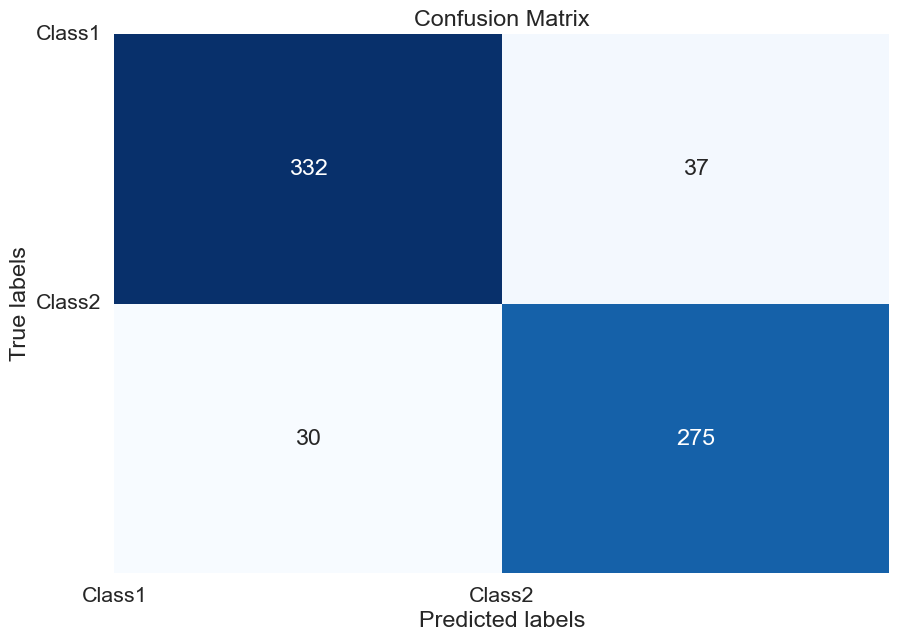

In [13]:
# Evaluate the model
from sklearn.metrics import mean_squared_error

#accuracy
gaussian_accuracy = accuracy_score(y_test, gaussian_y_pred)

print(f'Model Accuracy: {gaussian_accuracy:.3f}')
# Calculate precision, recall, F1 score, and support
class_report = classification_report(y_test, gaussian_y_pred)
print("\nClassification Report:")
print(class_report)


# Assuming `y_test` are your true labels and `y_pred` are your model's predictions
conf_matrix = confusion_matrix(y_test, gaussian_y_pred)

# Define class names (adjust these to your specific class names)
class_names = ['Class1', 'Class2']  # Example class names, replace with your actual class names

# Generate tick marks for the confusion matrix
tick_marks = np.arange(len(class_names))

# Plotting
plt.figure(figsize=(10, 7))  # Set the figure size for the plot
sns.set(font_scale=1.4)  # Set the scale for font size
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)

# Aesthetics
plt.xlabel('Predicted labels')  # X-axis label
plt.ylabel('True labels')  # Y-axis label
plt.title('Confusion Matrix')  # Title of the plot
plt.xticks(tick_marks, class_names)  # Set the tick marks and class names for the x-axis
plt.yticks(tick_marks, class_names, rotation=0)  # Set the tick marks and class names for the y-axis, with no rotation
plt.show()  # Display the plot



## Estimating Errors and Interpeting the Evaluation

Model Accuracy: .90 
    This means that the model correctly predicts whether an email is spam or not 90 percent of the time.  

Classification Report: 

Precision: 0.92 and 0.89
    This high precision relates to low false positive rates. The model is very good at not labeling a non-spam email as spam. 

Recall: .91 and 0.90
    Recall is the ratio of correctly predicted positive observations to all observations in the actual class. The recall of 0.91 for non-spam emails indicates the model is good at identifying non-spam emails, and similarly, a recall of 0.90 for spam emails means it's quite adept at catching spam emails.

F1-Score:
    The F1 score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. An F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0. Both classes have an F1 score of 0.91, which is quite high, suggesting a well-balanced classification performance.
    
Support: 
    This is the number of actual occurrences of the class in the specified dataset. For non-spam, there are 369 instances, and for spam, there are 305 instances.

## Model Improvement
When observing the orgina stopword removal we noticed some symbols were kept that appeared more often in spam emails when just looking through the data. We decided that adjusting the cleaning or stopword removal the data could help improve the data. We decided to adjust the stopword by adding our own adjustments to remove special symbols and keep important ones so the model would be vectorized based only on actual words. One could expand on this and write more code to find out the best symbols to keep and get rid of to improve the model even more

In [14]:
stop_words = set(stopwords.words('english'))
# Define your custom stopwords, including specific symbols you want to remove
custom_stopwords = {'...', '``', "''", '--', '(', ')', '-', '[', ']', '{', '}', ';',  ',', '\\', '|', '&', '%', '@', '+', '=', '_', '~'}

# Symbols that you've decided might be important for spam detection
important_symbols = {'$', '£', '€', '!', '?', '#', '*', '<', '>', ':', '/','^'}

# Function to clean tokens, remove custom stopwords, and preserve important symbols
def clean_tokens(token_list):
    cleaned_tokens = []
    for word in token_list:
        # Remove any unimportant symbols from the word
        word_cleaned = ''.join(char for char in word if char.isalpha() or char in important_symbols)
        
        # Now check if the cleaned word is a stopword or entirely composed of unimportant symbols
        if word_cleaned.lower() not in stop_words and word_cleaned not in custom_stopwords and len(word_cleaned) > 0:
            # If the word is alphabetic or an important symbol, or a mix of those, keep it
            if any(char.isalpha() for char in word_cleaned) or all(char in important_symbols for char in word_cleaned):
                cleaned_tokens.append(word_cleaned)
    return cleaned_tokens

# Apply the function to each list of tokens in the Series
filtered_tokens = tokens.apply(clean_tokens)

# Display the first few entries of the tokenized, stopword-removed, and symbol-cleaned email data
filtered_tokens.head()


# Display the first few entries of the tokenized, stopword-removed, and symbol-cleaned email data

# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Assuming filtered_tokens is a list of lists (each inner list is a list of tokens from a document)
stems = [[stemmer.stem(word) for word in token_list] for token_list in filtered_tokens]
lemmas = [[lemmatizer.lemmatize(word) for word in token_list] for token_list in filtered_tokens]

# Function to learn word embeddings from the email dataset and create a feature vector for each email
def vectorize_with_word_embeddings(tokenized_data, labels):
    # Train a Word2Vec model
    word2vec_model = Word2Vec(sentences=tokenized_data, vector_size=100, window=5, min_count=1, workers=4)
    
    # Function to create a feature vector for each email by averaging its word vectors
    def email_feature_vector(email_tokens):
        # Remove out-of-vocabulary words and get their vectors
        vectors = [word2vec_model.wv[word] for word in email_tokens if word in word2vec_model.wv]
        # If an email has no words in the model, return a zero vector
        if len(vectors) == 0:
            return np.zeros(word2vec_model.vector_size)
        # Return the mean of the word vectors
        return np.mean(vectors, axis=0)
    
    # Apply the function to each email to get a list of feature vectors
    feature_vectors = np.array([email_feature_vector(email) for email in tokenized_data])
    
    # Create a DataFrame with the feature vectors
    vectorized_data = pd.DataFrame(feature_vectors)
    
    # Add the labels to the DataFrame
    vectorized_data['Label'] = labels.reset_index(drop=True)
    
    return vectorized_data

# Apply the function to your tokenized data and labels
vectorized_emails = vectorize_with_word_embeddings(tokens, balanced_data['Label'])

vectorized_emails.head()




,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,Label
0,0.224505,0.497025,-0.285136,-0.750334,-0.785400,-0.872497,0.394644,0.139677,-0.650574,-0.157990,...,-0.185777,-0.290068,0.294707,0.726818,-0.603222,0.155778,-0.972166,1.244780,-0.640538,1
1,0.101735,0.352621,-0.524305,-0.177441,-0.444359,-0.795316,0.661214,0.269369,-0.491531,-0.206056,...,-0.031856,-0.215764,0.257832,0.678192,-0.350959,0.099881,-1.080701,0.802466,-0.431256,0
2,0.282819,0.461356,-0.266041,-0.735087,-0.657854,-0.847596,0.311715,0.209944,-0.540041,-0.113867,...,-0.200049,-0.175096,0.417613,0.679126,-0.486537,0.006506,-0.984477,1.081807,-0.496085,1
3,-0.068639,0.431558,-0.684322,-0.299668,-0.597232,-0.777027,0.389156,0.446275,-0.573160,-0.469689,...,0.035392,-0.541567,0.058734,0.882687,-0.162306,0.524964,-0.858050,0.784043,-0.433263,0
4,0.405514,-0.042236,-0.305008,-0.597546,-0.483611,-0.884544,0.058889,0.323349,-0.490330,0.060744,...,-0.033300,-0.165541,0.309526,0.651684,-0.407503,-0.003887,-0.639323,0.869336,-0.313478,1


## Gaussian Nayes Model With Improvement
Here is the model with the philosohpy stated above we used for improving

In [15]:
#Define X and y
X = vectorized_emails.drop('Label', axis=1)  # Drop the 'Label' column to get features
y = vectorized_emails['Label']  # 'Label' column as the target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Gaussian Naive Bayes model
gaussian_model2 = GaussianNB()
gaussian_model2.fit(X_train, y_train)

# Predict labels for the test set using the updated model name
gaussian_y_pred = gaussian_model2.predict(X_test)

# Evaluate the model
gaussian_accuracy = accuracy_score(y_test, gaussian_y_pred)
gaussian_mse = mean_squared_error(y_test, gaussian_y_pred)

# Print accuracy and mean squared error
print(f'Model Accuracy: {gaussian_accuracy:.3f}')
print(f'Model Mean Squared Error: {gaussian_mse:.3f}')

# Calculate precision, recall, F1 score, and support using the updated predictions
class_report = classification_report(y_test, gaussian_y_pred)
print("\nClassification Report:")
print(class_report)


Model Accuracy: 0.911
Model Mean Squared Error: 0.089

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       369
           1       0.89      0.92      0.90       305

    accuracy                           0.91       674
   macro avg       0.91      0.91      0.91       674
weighted avg       0.91      0.91      0.91       674



## Cross Validation
We decided to improve the model using cross validation which gives us more accurate understanding of your model's ability to generalize to unseen data

In [16]:
# Define the number of folds for cross-validation
n_folds = 5

# Perform cross-validation and calculate the mean accuracy
scores = cross_val_score(gaussian_model, X, y, cv=n_folds, scoring='accuracy')
mean_accuracy = scores.mean()

print(f'Mean Accuracy with {n_folds}-Fold Cross-Validation: {mean_accuracy:.2f}')

# Initialize stratified K-Fold
stratified_kfold = StratifiedKFold(n_splits=n_folds)

# Perform cross-validation using stratified K-Fold
scores = cross_val_score(gaussian_model, X, y, cv=stratified_kfold, scoring='accuracy')

# Calculate precision and recall
precision = precision_score(y_test, gaussian_y_pred)
recall = recall_score(y_test, gaussian_y_pred)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")



Mean Accuracy with 5-Fold Cross-Validation: 0.92
Precision: 0.8889
Recall: 0.9180


## Learning Curve Model Validation
This helps identifying whether the model is overfitting or underfitting. Overfitting is when the model performs well on the training data but poorly on unseen data. Underfitting is when the model performs poorly on both. As seen there doesnt seem to be any overfitting or underfitting, and that the model is just right

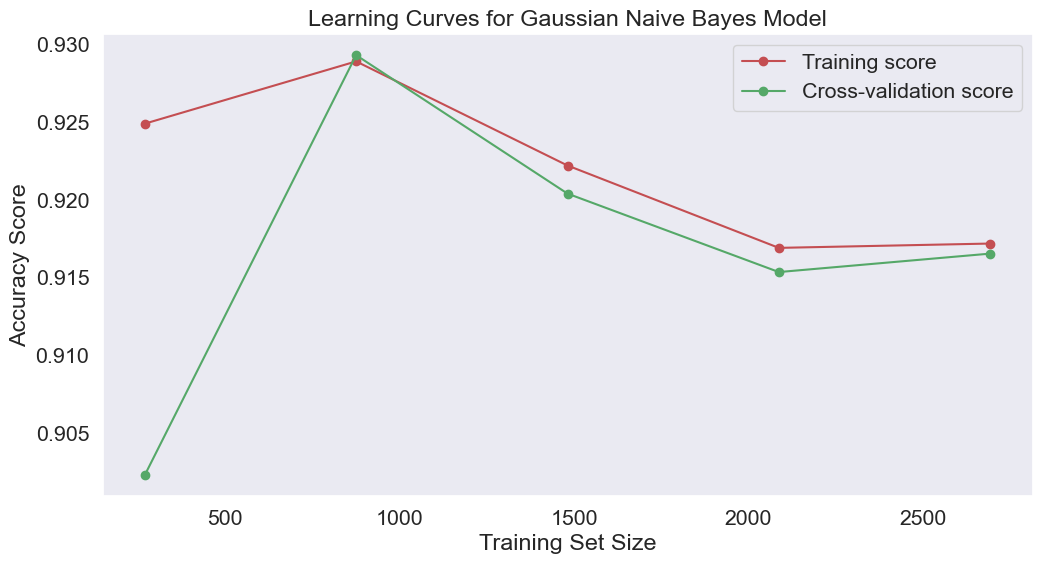

In [17]:
# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(gaussian_model, X, y, cv=5)
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

# Plot learning curves
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.title('Learning Curves for Gaussian Naive Bayes Model')
plt.xlabel('Training Set Size'), plt.ylabel('Accuracy Score'), plt.legend(loc="best")
plt.grid()
plt.show()

## Output Interpretation

Model Performance Metrics: The classification report suggests that the model has an accuracy of 91.1%, which means it correctly predicts whether an email is spam or not 91.1% of the time. The precision for class 0 (non-spam) is 94%, and for class 1 (spam) is 88%, indicating that the model is slightly better at identifying non-spam emails. The recall is 90% for non-spam and 93% for spam emails, meaning the model is slightly better at identifying all spam emails in the dataset. The F1-score, which is a balance between precision and recall, is 92% for non-spam and 90% for spam, showing good overall performance.

Learning Curve: The learning curve demonstrates the model's performance on both the training set and the validation set across different training set sizes. The plot suggests that the training score decreases slightly with more data, while the cross-validation score increases, converging towards the training score. This indicates that the model is not overfitting or underfitting, as the two scores converge with more data, suggesting that adding more data helps the model generalize better.

Learning Curve Plot: The graph shows the training and cross-validation scores. The training score starts high and decreases, suggesting that the model fits the training data well initially but then generalizes as more data is added. The cross-validation score increases with more data, which is typical as the model learns from a more comprehensive range of examples. The fact that both scores converge indicates that the model's performance is stabilizing and it is neither overfitting nor underfitting.

Overall, the model seems to perform well. Cross-validation indicates good generalization to unseen data, and the learning curve suggests that the model is well-balanced between bias and variance. However, to fully understand the model's performance, it would be helpful to look at other metrics such as the confusion matrix and ROC curve, and also to ensure that the dataset is balanced or that the metrics are interpreted in light of any imbalance.